<a href="https://colab.research.google.com/github/Foster1466/Tensorflow-in-practice/blob/master/Course_4_week_4(HW).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-12-26 09:08:00--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.002s  

2020-12-26 09:08:00 (38.6 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



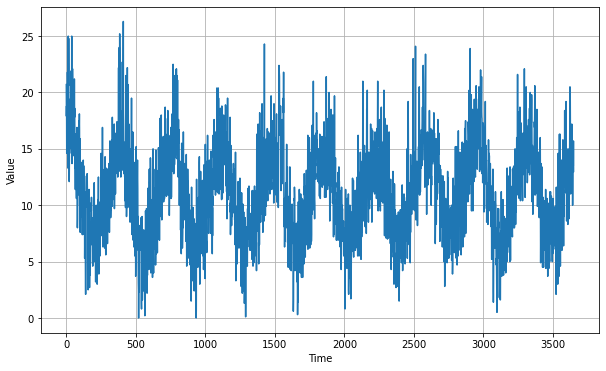

In [4]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter = ',')
    next(reader)
    count = 0
    for row in reader:
      temps.append(float(row[1]))
      time_step.append(count)
      count+= 1
series= np.array(temps)
time= np.array(time_step)
plt.figure(figsize= (10,6))
plot_series(time, series)

In [5]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series= tf.expand_dims(series, axis= -1)
  ds= tf.data.Dataset.from_tensor_slices(series)
  ds= ds.window(window_size+1, shift= 1, drop_remainder= True)
  ds= ds.flat_map(lambda w:w.batch(window_size+1))
  ds= ds.shuffle(shuffle_buffer)
  ds= ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
  ds= tf.data.Dataset.from_tensor_slices(series)
  ds= ds.window(window_size, shift=1, drop_remainder= True)
  ds= ds.flat_map(lambda w: w.batch(window_size))
  ds= ds.batch(32).prefetch(1)
  forecast= model.predict(ds)
  return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size= 64
batch_size= 256
train_set= windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.Sequential([
                             tf.keras.layers.Conv1D(filters= 32, kernel_size=5, strides=1, padding= 'causal', activation='relu', input_shape=[None,1]),
                             tf.keras.layers.LSTM(64, return_sequences=True),
                             tf.keras.layers.LSTM(64, return_sequences=True),
                             tf.keras.layers.Dense(30, activation='relu'),
                             tf.keras.layers.Dense(10, activation='relu'),
                             tf.keras.layers.Dense(1),
                             tf.keras.layers.Lambda(lambda x:x*400)
])
lr_schedule= tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
optimizer= tf.keras.optimizers.SGD(lr= 1e-8, momentum= 0.9)
model.compile(loss= tf.keras.losses.Huber(), optimizer= optimizer, metrics= ['mae'])
history= model.fit(train_set, epochs=100, callbacks= [lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 9s 31ms/step - loss: 31.0287 - mae: 31.5267
Epoch 2/100
10/10 [==============================] - 0s 27ms/step - loss: 30.7698 - mae: 31.2675
Epoch 3/100
10/10 [==============================] - 0s 28ms/step - loss: 29.9371 - mae: 30.4346
Epoch 4/100
10/10 [==============================] - 0s 29ms/step - loss: 28.6752 - mae: 29.1725
Epoch 5/100
10/10 [==============================] - 0s 29ms/step - loss: 27.2988 - mae: 27.7959
Epoch 6/100
10/10 [==============================] - 0s 30ms/step - loss: 25.7600 - mae: 26.2569
Epoch 7/100
10/10 [==============================] - 0s 29ms/step - loss: 24.0420 - mae: 24.5384
Epoch 8/100
10/10 [==============================] - 0s 29ms/step - loss: 21.3711 - mae: 21.8673
Epoch 9/100
10/10 [==============================] - 0s 29ms/step - loss: 18.2363 - mae: 18.7317
Epoch 10/100
10/10 [=====

(1e-08, 0.0001, 0.0, 60.0)

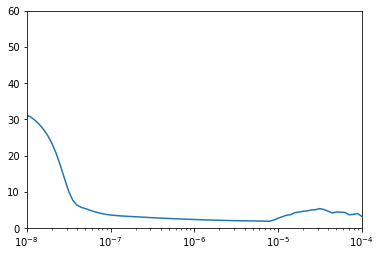

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters= 60, kernel_size=5, strides= 1, padding= 'causal', activation='relu',
                                                           input_shape= [None,1]),
                                    tf.keras.layers.LSTM(60, return_sequences=True),
                                    tf.keras.layers.LSTM(60, return_sequences=True), 
                                    tf.keras.layers.Dense(30, activation='relu'),
                                    tf.keras.layers.Dense(20, activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x*400)
])

optimizer= tf.keras.optimizers.SGD(lr= 1e-5, momentum=0.9)
model.compile(loss= tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history= model.fit(train_set,epochs=200)

Epoch 1/200
25/25 [==============================] - 3s 16ms/step - loss: 16.0105 - mae: 16.5047
Epoch 2/200
25/25 [==============================] - 0s 15ms/step - loss: 2.7184 - mae: 3.1849
Epoch 3/200
25/25 [==============================] - 0s 15ms/step - loss: 1.9532 - mae: 2.4078
Epoch 4/200
25/25 [==============================] - 0s 16ms/step - loss: 1.8220 - mae: 2.2739
Epoch 5/200
25/25 [==============================] - 0s 15ms/step - loss: 1.7791 - mae: 2.2314
Epoch 6/200
25/25 [==============================] - 0s 16ms/step - loss: 1.7464 - mae: 2.1968
Epoch 7/200
25/25 [==============================] - 0s 16ms/step - loss: 1.7098 - mae: 2.1599
Epoch 8/200
25/25 [==============================] - 0s 15ms/step - loss: 1.6867 - mae: 2.1353
Epoch 9/200
25/25 [==============================] - 0s 16ms/step - loss: 1.6960 - mae: 2.1447
Epoch 10/200
25/25 [==============================] - 0s 15ms/step - loss: 1.6707 - mae: 2.1187
Epoch 11/200
25/25 [===========================

In [24]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

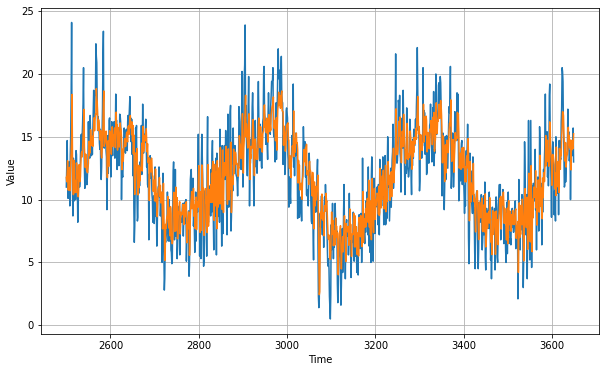

In [25]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [26]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7866765

In [27]:
print(rnn_forecast)

[11.763942 11.421168 12.28084  ... 14.124219 14.084464 15.240447]
